In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import torch
from torchvision import datasets , transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
src_path = "/kaggle/input/animals10/raw-img"
path = "/kaggle/working/raw-img"

shutil.copytree(src_path, path, dirs_exist_ok=True)

'/kaggle/working/raw-img'

In [4]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}
classes = os.listdir(path)

In [5]:
for category in classes:
    category_path = os.path.join(path, category)
    if os.path.isdir(category_path):
        eng_name = translate.get(category, category)
        eng_path = os.path.join(path, eng_name)
        if eng_name != category:
            os.rename(category_path, eng_path)

In [6]:
dataset = datasets.ImageFolder(root=path)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 26179
    Root location: /kaggle/working/raw-img


In [7]:
def count_items_classes(dataset):
    class_counts = {class_name: 0 for class_name in dataset.classes}

    for _, label in dataset.samples:
        class_counts[dataset.classes[label]] += 1

    return class_counts

In [9]:
num_of_items = count_items_classes(dataset)
print(num_of_items)

{'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


In [10]:
def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Num')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

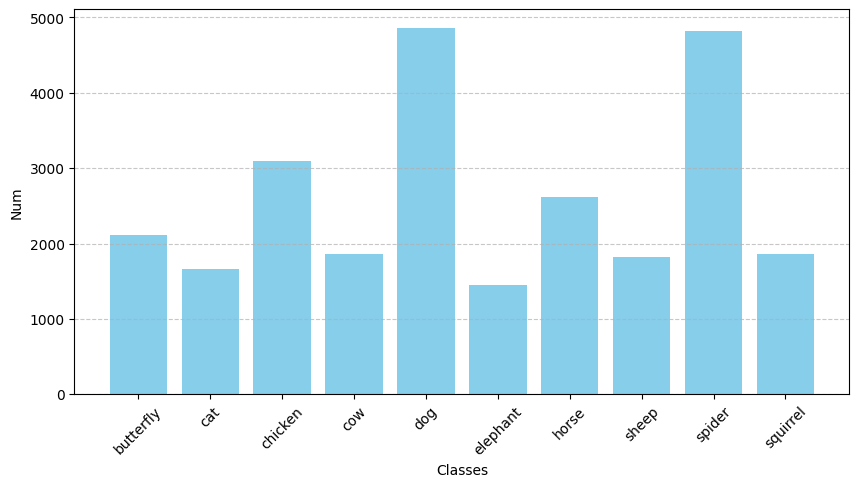

In [11]:
plot_class_distribution(num_of_items)

In [15]:
transform_data_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_data_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
test_size = int(0.2 * dataset_size)
val_size = dataset_size - train_size - test_size

In [13]:
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

In [16]:
train_dataset = Subset(datasets.ImageFolder(root=path, transform=transform_data_train), train_dataset.indices)
test_dataset = Subset(datasets.ImageFolder(root=path, transform=transform_data_test), test_dataset.indices)
val_dataset = Subset(datasets.ImageFolder(root=path, transform=transform_data_train), val_dataset.indices)

In [17]:
print(f"Train ds: ", len(train_dataset))
print(f"Val ds: ", len(val_dataset))
print(f"Test ds: ", len(test_dataset))

Train ds:  18325
Val ds:  2619
Test ds:  5235


In [18]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [19]:
def show_images(data, classes, num_images=10):
    data_iter = iter(data)
    samples = [next(data_iter) for _ in range(24)]
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for ax, (image, label) in zip(axes, samples):
        plt.sca(ax)
        imshow(image)
        ax.set_title(classes[label], fontsize=10)
        ax.axis("off")

    plt.show()

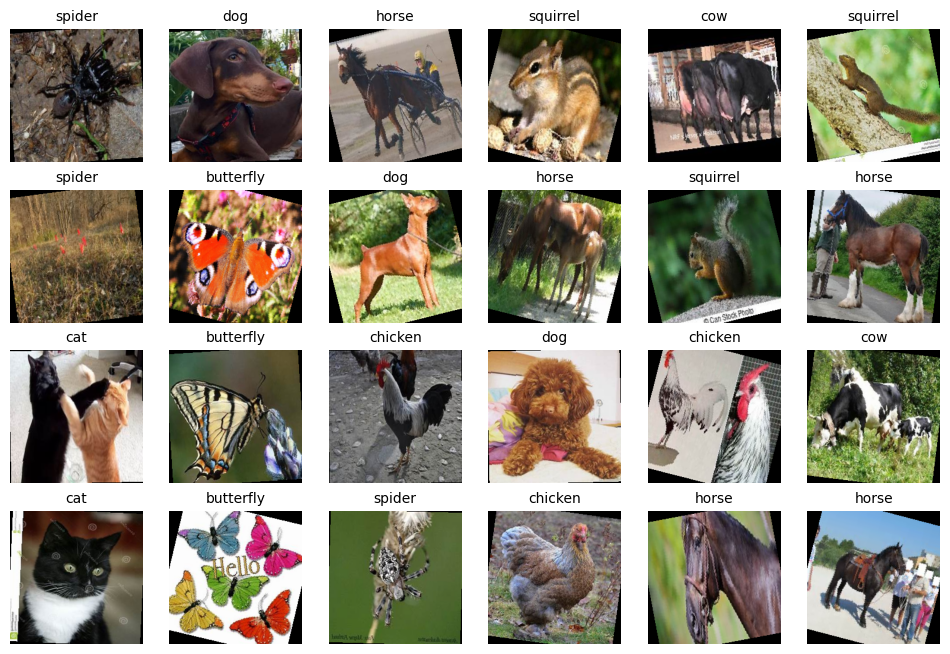

In [30]:
show_images(train_dataset, dataset.classes, num_images=24)

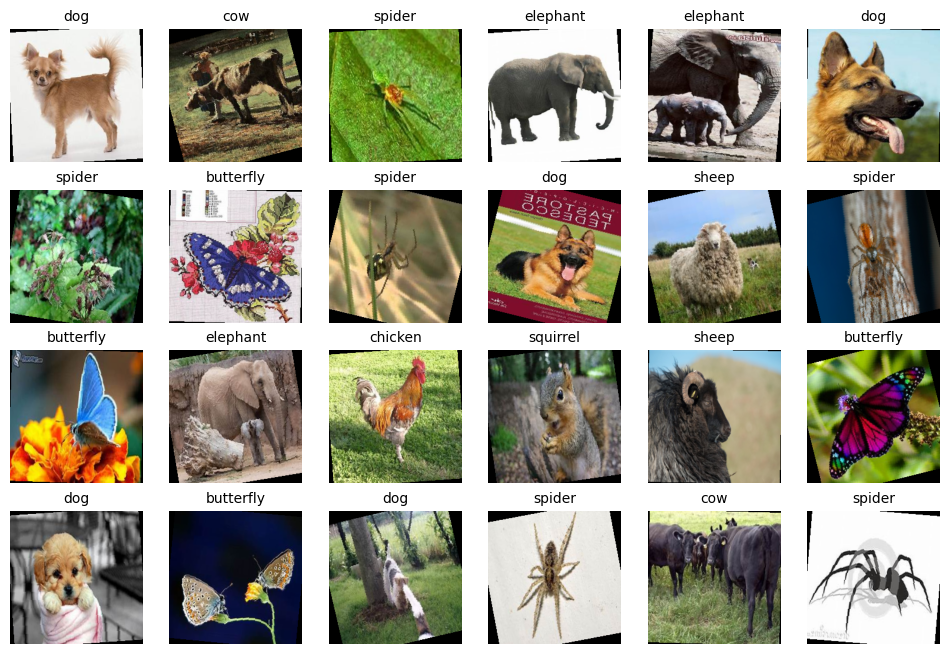

In [32]:
show_images(val_dataset, dataset.classes, num_images=24)

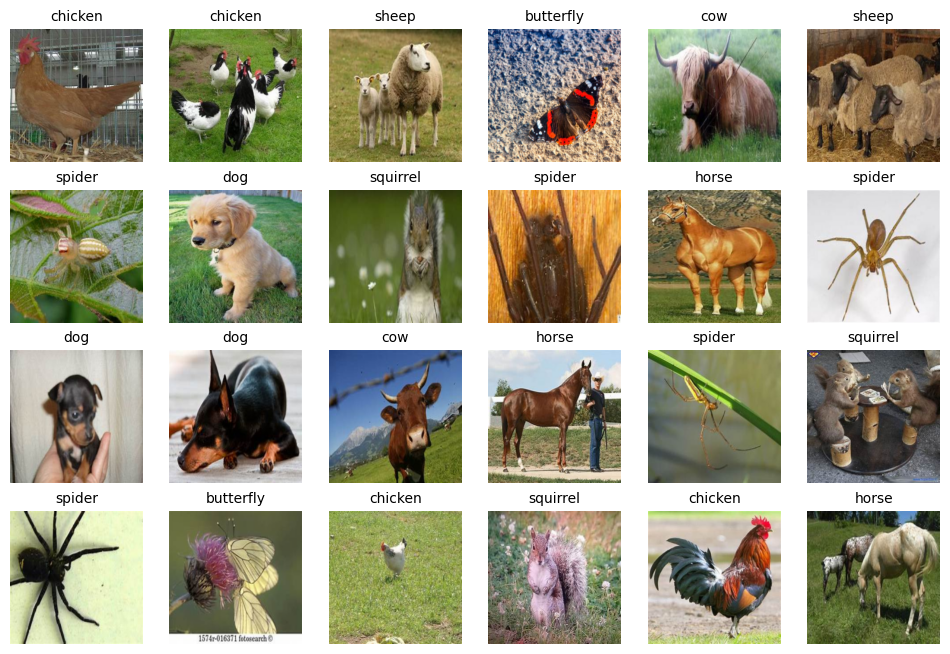

In [33]:
show_images(test_dataset, dataset.classes, num_images=24)

Conclusion:
The dataset has more than 26,000 images, which are divided into 10 classes. The classes are quite unbalanced, which is a serious disadvantage.

It was decided not to apply strong augmentation for this stage.

In general, the data has the correct labels. Although it was noticed when an image with a butterfly was labelled as a Spider (the only case noticed but kinda worried 'cause we have Butterfly lable itself). 

P.S. There were less serious and funny mistakes, for example, for some reason really often chipmunks and hamsters are listed in the class Squirrels. :D

For the next task:

In [26]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(val_dataset, "val_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

In [27]:
batch_size = 128

In [29]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=True, num_workers=2, pin_memory=True)